In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

In [2]:
def get_data_and_first_cleaning():
    rooth_path = '../rawdata/training/'
    failures_df = pd.read_csv(rooth_path + 'wind-farm-1-failures-training.csv')
    locations_df = pd.read_csv(rooth_path + "wind-farm-1-locations.csv")
    logs_df = pd.read_csv(rooth_path + 'wind-farm-1-logs-training.csv')
    metmast_df = pd.read_csv(rooth_path + 'wind-farm-1-metmast-training.csv', sep=';')
    signals_df = pd.read_csv(rooth_path + 'wind-farm-1-signals-training.csv', sep=';')
    power_df = pd.read_csv(rooth_path + 'Power_curve.csv', sep=',')
#     costs_df = pd.read_csv(rooth_path + 'HTW_Costs.csv')
    
    # pass all the Timestamps to date-time format
    failures_df['Timestamp'] = pd.to_datetime(failures_df['Timestamp'])
    logs_df['Timestamp'] = pd.to_datetime(logs_df['TimeDetected'])
    logs_df = logs_df.drop(columns=['TimeDetected','UnitTitleDestination'])
    metmast_df['Timestamp'] = pd.to_datetime(metmast_df['Timestamp'])
    signals_df['Timestamp'] = pd.to_datetime(signals_df['Timestamp'])
     
    # Drop Columns with std=0 by DA
    drop_features_metmast = ['Anemometer1_Offset', 'Anemometer2_Freq', 'Anemometer2_Offset', 'Min_Raindetection',
                             'Avg_Raindetection', 'Anemometer1_CorrGain', 'Anemometer1_CorrOffset',
                             'Anemometer2_CorrGain', 'Anemometer2_CorrOffset', 'DistanceAirPress', 
                             'AirRessureSensorZeroOffset']
    metmast_df = metmast_df.drop(columns=drop_features_metmast)
    
    drop_features_signals = ['Prod_LatestAvg_ActPwrGen2', 'Prod_LatestAvg_ReactPwrGen2']
    signals_df = signals_df.drop(columns=drop_features_signals)
    
    failures_df = failures_df.drop(columns='Remarks')
    
    #Fill na by interpolate
    signals_df = signals_df.bfill()
    
    return failures_df, locations_df, logs_df, metmast_df, signals_df, power_df

In [3]:
failures_df, locations_df, logs_df, metmast_df, signals_df, power_df = get_data_and_first_cleaning()

In [4]:
failures_df.head()

,Turbine_ID,Component,Timestamp
0,T11,GENERATOR,2016-03-03 19:00:00+00:00
1,T06,HYDRAULIC_GROUP,2016-04-04 18:53:00+00:00
2,T07,GENERATOR_BEARING,2016-04-30 12:40:00+00:00
3,T09,GENERATOR_BEARING,2016-06-07 16:59:00+00:00
4,T07,TRANSFORMER,2016-07-10 03:46:00+00:00


In [5]:
# Function to find str in columns of df
def component(component, col):
    pair_comp_col=[]
    for i in col:
        if component in i:
            pair_comp_col.append(i)
    return pair_comp_col

In [6]:
# Classification label for failures
failures_generator = failures_df[failures_df['Component'] == 'GENERATOR']
failures_generator.replace('GENERATOR', 1, inplace=True)
failures_gen_bear = failures_df[failures_df['Component'] == 'GENERATOR_BEARING']
failures_gen_bear.replace('GENERATOR_BEARING', 1, inplace=True)
failures_hyd = failures_df[failures_df['Component'] == 'HYDRAULIC_GROUP']
failures_hyd.replace('HYDRAULIC_GROUP', 1, inplace=True)
failures_gearbox = failures_df[failures_df['Component'] == 'GEARBOX']
failures_gearbox.replace('GEARBOX', 1, inplace=True)
failures_transf = failures_df[failures_df['Component'] == 'TRANSFORMER']
failures_transf.replace('TRANSFORMER', 1, inplace=True)

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/pandas/core/frame.py:4527: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [7]:
#Features to create each DF
def create_features(df):
    time_id = ['Timestamp', 'Turbine_ID']
    pair_hyd = component('Hyd', df.columns)
    pair_trafo = component('Trafo', df.columns)
    pair_gear = component('Gear', df.columns)
    pair_gen = component('Gen', df.columns)
    pair_rot = component('Rtr', df.columns)
    pair_amb = component('Amb', df.columns)
    pair_blds = component('Blds', df.columns)
    pair_cont = component('Cont', df.columns)
    pair_nac = component('Nac', df.columns)
    pair_spin = component('Spin', df.columns)
    pair_bus = component('Busbar', df.columns)
    pair_vol = component('Volt', df.columns)
    
    #Create DF for each component
    df_generator = df[time_id + pair_gen + pair_rot + pair_amb + pair_blds + pair_cont + pair_nac + pair_spin + pair_bus + pair_hyd]
    df_gen_bear = df[time_id + pair_gen + pair_rot + pair_amb + pair_blds + pair_cont + pair_nac + pair_spin + pair_bus + pair_hyd]
    df_transformer = df[time_id + pair_trafo + pair_rot + pair_amb + pair_blds + pair_cont + pair_nac + pair_spin + pair_bus + pair_vol] 
    df_hydraulic = df[time_id + pair_hyd + pair_rot + pair_amb + pair_blds + pair_cont + pair_nac + pair_spin + pair_bus] 
    df_gearbox = df[time_id + pair_gear + pair_rot + pair_amb + pair_blds + pair_cont + pair_nac + pair_spin + pair_bus + pair_hyd]
    
    return df_generator, df_gen_bear, df_transformer, df_hydraulic, df_gearbox

In [8]:
df_generator, df_gen_bear, df_transformer, df_hydraulic, df_gearbox = create_features(signals_df)

In [9]:
# Merge DF Failures with DF of each component to know the moment of each failure
generator_final = df_generator.merge(failures_generator, on=['Timestamp','Turbine_ID'], how='outer')
gen_bear_final = df_gen_bear.merge(failures_gen_bear, on=['Timestamp', 'Turbine_ID'], how='outer')
hyd_final = df_hydraulic.merge(failures_hyd, on=['Timestamp', 'Turbine_ID'], how='outer')
gearbox_final = df_gearbox.merge(failures_gearbox, on=['Timestamp', 'Turbine_ID'], how='outer')
transf_final = df_transformer.merge(failures_transf, on=['Timestamp', 'Turbine_ID'], how='outer')

In [10]:
#Fill na on component column
generator_final['Component'].fillna(0, inplace=True)
gen_bear_final['Component'].fillna(0, inplace=True)
hyd_final['Component'].fillna(0, inplace=True)
gearbox_final['Component'].fillna(0, inplace=True)
transf_final['Component'].fillna(0, inplace=True)

In [11]:
# Set Timestamp as Index
generator_final.set_index('Timestamp', inplace=True)
gen_bear_final.set_index('Timestamp', inplace=True)
hyd_final.set_index('Timestamp', inplace=True)
gearbox_final.set_index('Timestamp', inplace=True)
transf_final.set_index('Timestamp', inplace=True)

In [12]:
# Sort Index
generator_final.sort_index(inplace=True)
gen_bear_final.sort_index(inplace=True)                                      
hyd_final.sort_index(inplace=True)
gearbox_final.sort_index(inplace=True)
transf_final.sort_index(inplace=True)

In [13]:
# Reset Index to group by Timestamp and Turbine_ID
generator_final.reset_index(inplace=True)
gen_bear_final.reset_index(inplace=True)                                      
hyd_final.reset_index(inplace=True)
gearbox_final.reset_index(inplace=True)
transf_final.reset_index(inplace=True)

In [14]:
def prepare_data(df, strategy='mean'):
    if strategy == 'mean':
        df = df.groupby(by=['Turbine_ID','Timestamp']).mean()
    else:
        df = df.grouby(by=['Turbine_ID', 'Timestamp']).max()
    
    # Fill na by interpolate
    df = df.bfill().reset_index()
        
    return df

In [15]:
df_generator_final=prepare_data(generator_final)
df_gen_bear_final=prepare_data(gen_bear_final)
df_hyd_final=prepare_data(hyd_final)
df_gearbox_final=prepare_data(gearbox_final)
df_transf_final=prepare_data(transf_final)

In [16]:
print(df_generator_final.isnull().values.any())
print(df_gen_bear_final.isnull().values.any())
print(df_hyd_final.isnull().values.any())
print(df_gearbox_final.isnull().values.any())
print(df_transf_final.isnull().values.any())

False
False
False
False
False


In [17]:
df_generator_final[df_generator_final['Turbine_ID']=='T01']['Timestamp'].value_counts()

2017-01-16 22:10:00+00:00    1
2017-01-18 18:20:00+00:00    1
2016-08-17 20:00:00+00:00    1
2017-06-10 16:50:00+00:00    1
2016-04-03 19:40:00+00:00    1
                            ..
2016-11-09 10:40:00+00:00    1
2016-09-02 10:30:00+00:00    1
2016-03-14 04:20:00+00:00    1
2016-01-06 04:10:00+00:00    1
2017-05-05 15:40:00+00:00    1
Name: Timestamp, Length: 87140, dtype: int64

In [18]:
def fill_na_by_turbine(df):
    turbines = ['T01', 'T06', 'T07', 'T09', 'T11']
    df_ = pd.DataFrame(columns=df.columns)
    for turbine in turbines:
        df1 = df.loc[df['Turbine_ID']==turbine]
        if df1['Component'].nunique()>1:
            index = df1[df1['Component']==1]
            index['date'] = index['Timestamp']
            index = index[['date','Timestamp', 'Turbine_ID']]
            df_merged = df1.merge(index, how='left', on=['Turbine_ID','Timestamp'])
            df_merged = df_merged.fillna(method='bfill')
            
            #If there is not a failure after, hold present date
            df_merged['date'] = df_merged['date'].fillna(df_merged['Timestamp'])
            
            df_merged['TTF'] = round((df_merged['date'] - 
                                      df_merged['Timestamp']) / np.timedelta64(1, 'D'),0)
        else:
            df_merged = df1
            df_merged['date'] = df_merged['Timestamp']
#             df1 = df1[['date','Timestamp', 'Turbine_ID']]
#             df_merged = df.merge(df1, how='left', on=['Turbine_ID','Timestamp'])
            
#             df_merged['date'] = df_merged['date'].fillna(df_merged['Timestamp'])
            df_merged['TTF'] = 0 # df_merged['date'] - df_merged['Timestamp'] 

        #Drop Column Date
        df_final = df_merged.drop(columns='date')

        #df_final['TTF'] = df_final['TTF'].dt.days

        df_ = pd.concat([df_, df_final])

    return df_
        


In [19]:
generator_df = fill_na_by_turbine(df_generator_final)
gen_bear_df = fill_na_by_turbine(df_gen_bear_final)
hyd_df = fill_na_by_turbine(df_hyd_final)
gearbox_df = fill_na_by_turbine(df_gearbox_final)
transf_df = fill_na_by_turbine(df_transf_final)

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



In [20]:
def Failure_Time_Horizon(days, period):
    if 2 <= days <= period:
        Flag=1
    else:
        Flag=0
    return Flag

In [21]:
generator_df['60_days'] = generator_df.apply(lambda x: Failure_Time_Horizon(x['TTF'], 60),axis=1)
gen_bear_df['60_days'] = gen_bear_df.apply(lambda x: Failure_Time_Horizon(x['TTF'], 60),axis=1)
hyd_df['60_days'] = hyd_df.apply(lambda x: Failure_Time_Horizon(x['TTF'], 60),axis=1)
gearbox_df['60_days'] = gearbox_df.apply(lambda x: Failure_Time_Horizon(x['TTF'], 60),axis=1)
transf_df['60_days'] = transf_df.apply(lambda x: Failure_Time_Horizon(x['TTF'], 60),axis=1)

In [22]:
generator_df['30_days'] = generator_df.apply(lambda x: Failure_Time_Horizon(x['TTF'], 30),axis=1)
gen_bear_df['30_days'] = gen_bear_df.apply(lambda x: Failure_Time_Horizon(x['TTF'], 30),axis=1)
hyd_df['30_days'] = hyd_df.apply(lambda x: Failure_Time_Horizon(x['TTF'], 30),axis=1)
gearbox_df['30_days'] = gearbox_df.apply(lambda x: Failure_Time_Horizon(x['TTF'], 30),axis=1)
transf_df['30_days'] = transf_df.apply(lambda x: Failure_Time_Horizon(x['TTF'], 30),axis=1)

In [23]:
generator_df['10_days'] = generator_df.apply(lambda x: Failure_Time_Horizon(x['TTF'], 10),axis=1)
gen_bear_df['10_days'] = gen_bear_df.apply(lambda x: Failure_Time_Horizon(x['TTF'], 10),axis=1)
hyd_df['10_days'] = hyd_df.apply(lambda x: Failure_Time_Horizon(x['TTF'], 10),axis=1)
gearbox_df['10_days'] = gearbox_df.apply(lambda x: Failure_Time_Horizon(x['TTF'], 10),axis=1)
transf_df['10_days'] = transf_df.apply(lambda x: Failure_Time_Horizon(x['TTF'], 10),axis=1)

# Feature Selection

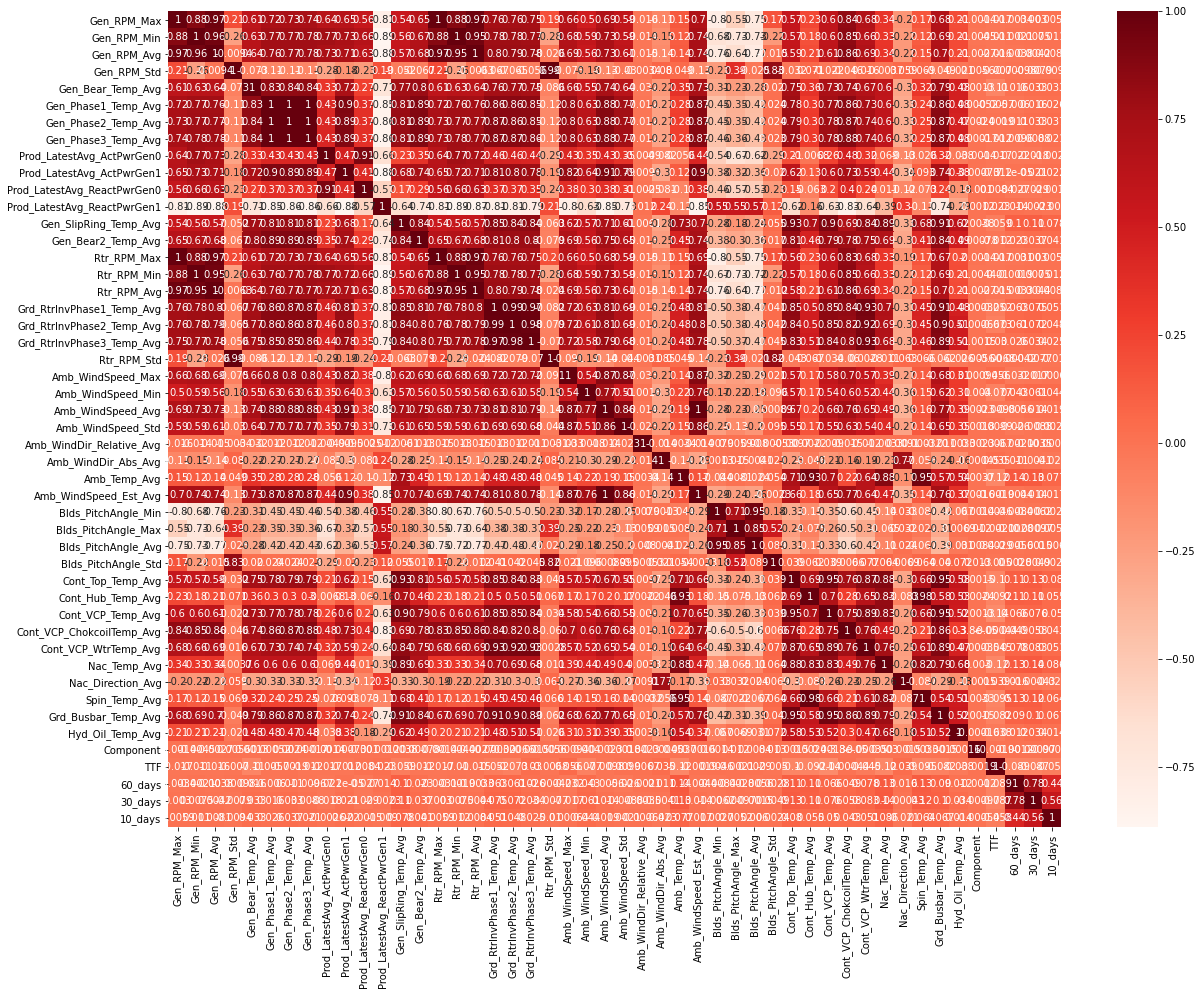

In [27]:
#Using Pearson Correlation
plt.figure(figsize=(20,15))
cor = generator_df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [40]:
generator_df.columns

Index(['Turbine_ID', 'Timestamp', 'Gen_RPM_Max', 'Gen_RPM_Min', 'Gen_RPM_Avg',
       'Gen_RPM_Std', 'Gen_Bear_Temp_Avg', 'Gen_Phase1_Temp_Avg',
       'Gen_Phase2_Temp_Avg', 'Gen_Phase3_Temp_Avg',
       'Prod_LatestAvg_ActPwrGen0', 'Prod_LatestAvg_ActPwrGen1',
       'Prod_LatestAvg_ReactPwrGen0', 'Prod_LatestAvg_ReactPwrGen1',
       'Gen_SlipRing_Temp_Avg', 'Gen_Bear2_Temp_Avg', 'Rtr_RPM_Max',
       'Rtr_RPM_Min', 'Rtr_RPM_Avg', 'Grd_RtrInvPhase1_Temp_Avg',
       'Grd_RtrInvPhase2_Temp_Avg', 'Grd_RtrInvPhase3_Temp_Avg', 'Rtr_RPM_Std',
       'Amb_WindSpeed_Max', 'Amb_WindSpeed_Min', 'Amb_WindSpeed_Avg',
       'Amb_WindSpeed_Std', 'Amb_WindDir_Relative_Avg', 'Amb_WindDir_Abs_Avg',
       'Amb_Temp_Avg', 'Amb_WindSpeed_Est_Avg', 'Blds_PitchAngle_Min',
       'Blds_PitchAngle_Max', 'Blds_PitchAngle_Avg', 'Blds_PitchAngle_Std',
       'Cont_Top_Temp_Avg', 'Cont_Hub_Temp_Avg', 'Cont_VCP_Temp_Avg',
       'Cont_VCP_ChokcoilTemp_Avg', 'Cont_VCP_WtrTemp_Avg', 'Nac_Temp_Avg',
       'Nac

In [41]:
gen_features_drop = ['Gen_RPM_Max', 'Gen_RPM_Max', 'Gen_Phase1_Temp_Avg','Gen_Phase3_Temp_Avg', 'Amb_WindSpeed_Est_Avg',
                     'Blds_PitchAngle_Max', 'Blds_PitchAngle_Min', 'Prod_LatestAvg_ReactPwrGen1', 'Rtr_RPM_Min', 'Rtr_RPM_Max']

In [43]:
generator_df = generator_df.drop(columns=gen_features_drop)

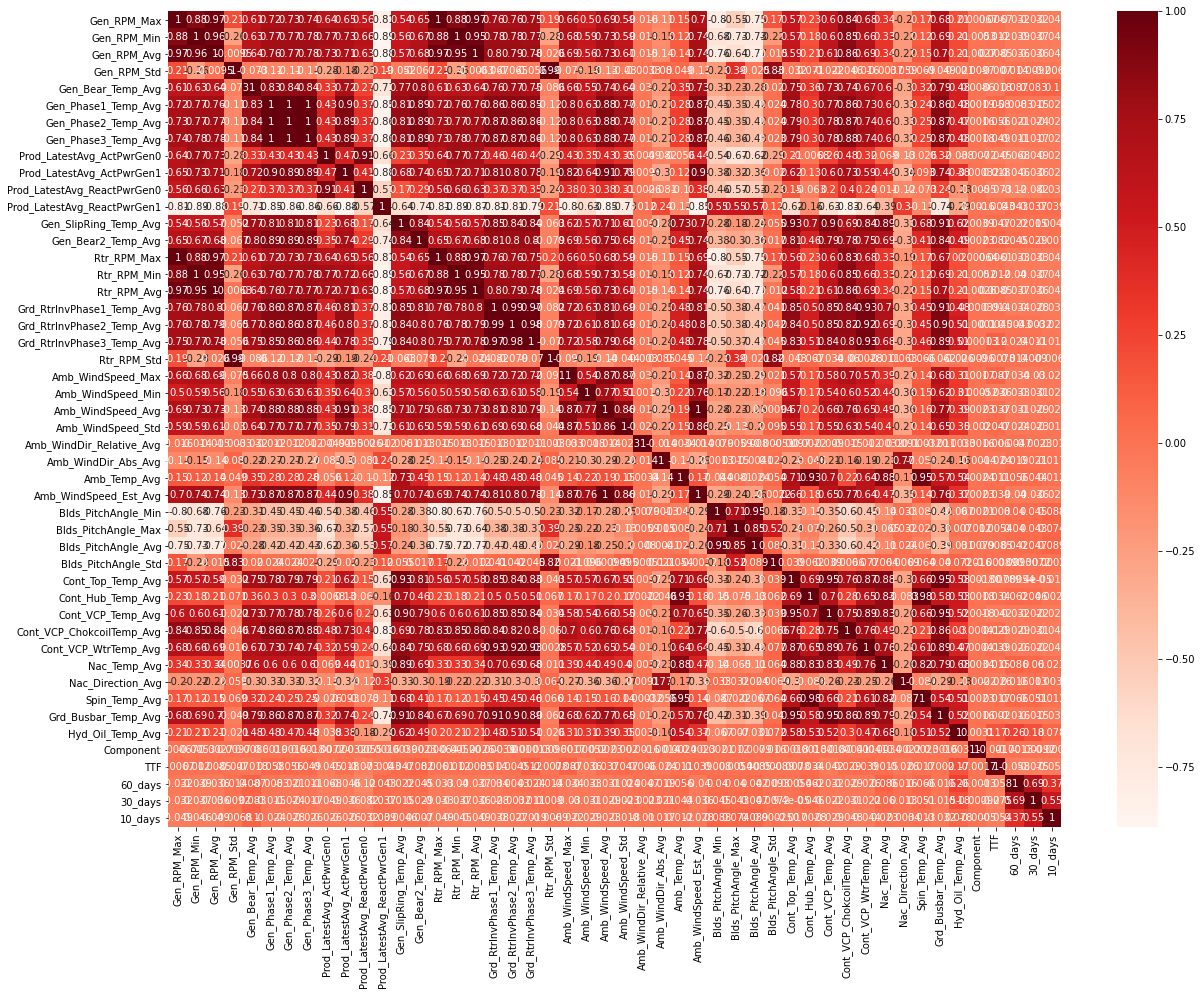

In [45]:
plt.figure(figsize=(20,15))
cor = gen_bear_df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
def add_features(df_in, rolling_win_size):
    """Add rolling average and rolling standard deviation for sensors readings using fixed rolling window size.
    Args:
            df_in (dataframe)     : The input dataframe to be proccessed (training or test)
            rolling_win_size (int): The window size, number of cycles for applying the rolling function
    Returns:
            dataframe: contains the input dataframe with additional rolling mean and std for each sensor
    """
    sensor_cols = []
    for i in df_in.keys()[2:]:
        sensor_cols.append(i)
    sensor_av_cols = [nm+'_av' for nm in sensor_cols]
    sensor_sd_cols = [nm+'_sd' for nm in sensor_cols]
    df_out = pd.DataFrame()
    ws = rolling_win_size
    #calculate rolling stats for each engine id
    for m_id in pd.unique(df_in.Turbine_ID):
        # get a subset for each engine sensors
        df_engine = df_in[df_in['Turbine_ID'] == m_id]
        df_sub = df_engine[sensor_cols]
        # get rolling mean for the subset
        av = df_sub.rolling(ws, min_periods=1).mean()
        av.columns = sensor_av_cols
        # get the rolling standard deviation for the subset
        sd = df_sub.rolling(ws, min_periods=1).std().fillna(0)
        sd.columns = sensor_sd_cols
        # combine the two new subset dataframes columns to the engine subset
        new_ftrs = pd.concat([df_engine,av,sd], axis=1)
        # add the new features rows to the output dataframe
        df_out = pd.concat([df_out,new_ftrs])
    return df_out

In [29]:
def prepare_train_test(df):
    last_date = df['Timestamp'].iloc[-1]
    split = last_time - pd.DateOffset(months=3)
    df_train = df[df['Timestamp'] < split]
    df_test = df[df['Timestamp'] >= split]
    
    return df_train, df_test

In [24]:
# def timestamp_round_down(df, time_column='Timestamp'):
#     'Arredondar os intervalos de tempo para os 10 minutos anteriores'
#     df[time_column] = df.apply(lambda x: x[time_column] - datetime.timedelta(minutes=x[time_column].minute % -10,seconds=x[time_column].second, microseconds=x[time_column].microsecond),axis=1)
#     return df

In [25]:
# def time_transform(df, time_column='Timestamp'):
#     'Transformar as colunas referentes a tempo no data typw tempo'
# #     df[time_column] = pd.to_datetime(df[time_column].str[:19])
#     # df[time_column] = df[time_column].dt.tz_localize('GMT')
#     df[time_column] = df[time_column].dt.tz_convert(None)
#     return df